In [6]:
# import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from cmlreaders import CMLReader, get_data_index
import os
from sklearn.externals import joblib
from utils import*

EPSILON = 1.0e-10 # add small number when taking log(power)
BUFFER = 1.0 # buffer window for computing power

In [7]:
freq = 6  # frequency
subject = 'R1154D'

In [8]:
freqs = [freq]
experiment = 'FR1'
rootdir = '/'
report_db_location = rootdir + "/scratch/report_database/"
df = get_data_index("r1", rootdir = rootdir) # grab all subject and experiement combinations

subject_df = df[df['subject'] == subject]

# print out all experiment for subject
print('subject {} experiments {}'.format(subject, subject_df['experiment'].unique()))

subect_df = subject_df[(subject_df['experiment'] == experiment) | (subject_df['experiment'] == 'cat'+ experiment)]
experiment_session_vec = subject_df[['experiment', 'session']]
n_sessions = len(experiment_session_vec['session'])

subject R1154D experiments ['FR1' 'FR3' 'PS2.1' 'TH1']


In [9]:
# for exp_sess in experiment_session_vec.values:
exp_sess = experiment_session_vec.values[0]
experiment, session = exp_sess
reader = CMLReader(subject = subject, experiment = experiment, session = session, localization=0, montage=0, rootdir=rootdir)
sess_events = reader.load('task_events')
pairs = reader.load("pairs")
window_size = 100 # window size to average over (ms)

# for window_size in window_sizes
# functional connectivity using word events
conn_mat_word  = construct_model_based_connectivity('WORD', reader, pairs, BUFFER, freqs, EPSILON, window_size = window_size)

# functional connectivity using count down start
conn_mat_cd  = construct_model_based_connectivity('COUNTDOWN_START', reader, pairs, BUFFER, freqs, EPSILON, window_size = window_size)

/home2/tungphan/.conda/envs/supereeg/lib/python3.6/site-packages/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1154D/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1154D/tal/R1154D_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home2/tungphan/.conda/envs/supereeg/lib/python3.6/site-packages/cmlreaders/readers/electrodes.py:236: MissingCoordinatesWarning: Could not load MNI coordinates
  "Could not load MNI coordinates"))
/home2/tungphan/.conda/envs/supereeg/lib/python3.6/site-packages/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1154D/experiments/FR1/sessions/0/ephys/current_processed/sources.json
/data/eeg/R1154D/eeg.noreref/R1154D_FR1_0_10May16_1745.params.txt
/data/eeg/R1154D/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning

CPP total time wavelet loop:  8.183781147003174


/home2/tungphan/.conda/envs/supereeg/lib/python3.6/site-packages/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1154D/experiments/FR1/sessions/0/ephys/current_processed/sources.json
/data/eeg/R1154D/eeg.noreref/R1154D_FR1_0_10May16_1745.params.txt
/data/eeg/R1154D/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home2/tungphan/.conda/envs/supereeg/lib/python3.6/site-packages/ptsa/data/timeseries.py:361: UserWarning: The filtered method is not very flexible. Consider using filters in ptsa.data.filters instead.
  warnings.warn("The filtered method is not very flexible. "
/home2/tungphan/.conda/envs/supereeg/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, whic

CPP total time wavelet loop:  2.3861026763916016


In [11]:
print(conn_mat_word.shape, conn_mat_cd.shape)  # print shapes of connectivity matrices

(110, 110) (110, 110)


In [12]:
# demo of VAR model
freqs = [110]
event_type  = 'COUNTDOWN_START'
window_size = 100
sess_events = reader.load('task_events')
events = sess_events[sess_events.type == event_type] # get events 

rel_start, rel_stop = 0,0
if event_type == 'WORD':
    rel_stop = 1366
if event_type == 'COUNTDOWN_START': 
    countdown_end_events = sess_events[sess_events.type == 'COUNTDOWN_END']
    countdown_times = []
    for i in np.arange(len(countdown_end_events)):
        countdown_times.append(countdown_end_events.iloc[i]['mstime'] - events.iloc[i]['mstime'])
    rel_stop = np.min(countdown_times)
else:
    rel_stop = 1366

events_eeg = reader.load_eeg(events, rel_start=rel_start, rel_stop=rel_stop, scheme=pairs)
events_eeg = events_eeg.to_ptsa()
events_eeg = events_eeg.filtered(freq_range=[58.0,62.0])
events_eeg = events_eeg.add_mirror_buffer(BUFFER)
wf = morlet.MorletWaveletFilter(events_eeg, freqs = freqs)
power_wavelet, phase_wavelet = wf.filter()
power_wavelet = power_wavelet.remove_buffer(BUFFER)
power_wavelet = power_wavelet.transpose('channel', 'event', 'time', 'frequency')
power_wavelet = np.log10(power_wavelet + EPSILON) # log transform
n_times = power_wavelet.shape[2]
intervals = np.array_split(np.arange(n_times), int(n_times/window_size))
power_wavelet_aggregate = np.zeros(shape = list(power_wavelet.shape[:2]) + [len(intervals)])
for i in np.arange(len(intervals)):
    power_wavelet_aggregate[:,:,i] = power_wavelet[:,:,intervals[i],0].mean('time')

dims =  power_wavelet_aggregate.shape 
power_wavelet_aggregate = power_wavelet_aggregate.reshape(dims[0], dims[1]*dims[2]) # reformat timeseries into NxT where N is number of electrodes, T is number of time periods 
model = VAR(power_wavelet_aggregate[:,:].T) # contruct VAR model

/home2/tungphan/.conda/envs/supereeg/lib/python3.6/site-packages/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1154D/experiments/FR1/sessions/0/ephys/current_processed/sources.json
/data/eeg/R1154D/eeg.noreref/R1154D_FR1_0_10May16_1745.params.txt
/data/eeg/R1154D/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home2/tungphan/.conda/envs/supereeg/lib/python3.6/site-packages/ptsa/data/timeseries.py:361: UserWarning: The filtered method is not very flexible. Consider using filters in ptsa.data.filters instead.
  warnings.warn("The filtered method is not very flexible. "
/home2/tungphan/.conda/envs/supereeg/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, whic

CPP total time wavelet loop:  2.4849510192871094


In [28]:
results = model.fit(maxlags = 3) # fit model with lag 3 
print(results.fittedvalues) # print fitted values

[[4.46628124 4.44664975 4.37717268 ... 4.60802846 4.48460468 4.65189424]
 [4.54503581 4.49809402 4.54991544 ... 4.50056075 4.48964756 4.57449228]
 [4.44719759 4.52803869 4.51508129 ... 4.62469138 4.59997308 4.69603835]
 ...
 [4.57075512 4.58197621 4.49818452 ... 4.51362961 4.55287439 4.58164273]
 [4.4810954  4.5421817  4.46764277 ... 4.62670912 4.4660113  4.63595751]
 [4.46219758 4.50255163 4.58692481 ... 4.55033546 4.415272   4.56604018]]


In [29]:
# put into a dataframe for plotting purposes
frame = pd.DataFrame({'actual':results.y[3:10003,1], 'fitted':results.fittedvalues[:10000,1]})
frame['actual_gamma'] = results.y[3:10003,1]
frame['fitted_gamma'] = results.fittedvalues[:10000,1]

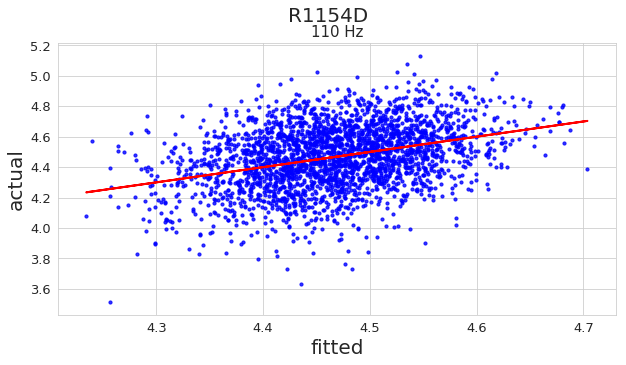

In [36]:
import seaborn as sns
sns.set_style('whitegrid')
fig, ax = plt.subplots(1,1, figsize = (10,5), sharey = False)
sns.regplot('fitted', 'actual', data = frame, ax = ax, fit_reg = False, scatter_kws = {'s':10}, color = 'blue')
ax.plot('fitted', 'fitted', data = frame, linewidth = 2, color = 'red')
ax.set_xlabel('fitted', size = 20)
ax.set_ylabel('actual', size = 20)
ax.tick_params(axis = 'both', labelsize = 13)
ax.set_title(str(freqs[0]) + " Hz", size =15)

fig.suptitle(subject, size = 20)
fig.savefig('model_fit.png', dpi = 1000)